# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


In [2]:
### Load pickled data
training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
### Basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


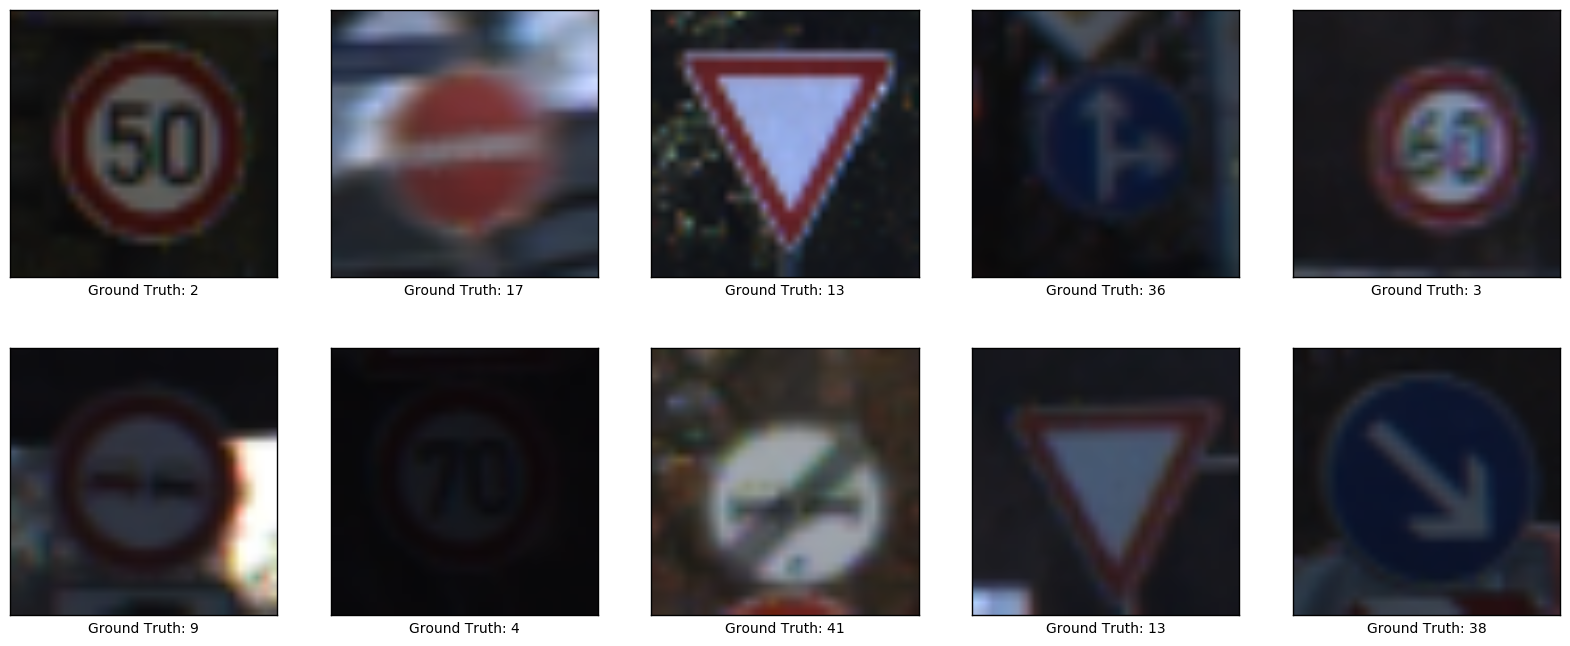

In [4]:
### Data exploration visualization
fig = plt.figure(figsize=(20, 8))

image_seq = np.random.randint(1,len(X_train),10)

for ind,val in enumerate(image_seq):
    img = fig.add_subplot(2,5,ind+1)
    plt.imshow(X_train[val-1])
    #Add corresponding label
    img.set_xlabel("Ground Truth: {0}".format(y_train[val-1]))
    #Remove the axis ticks
    img.set_xticks([])
    img.set_yticks([])

plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German T

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Preprocess data
# Grayscale conversion
'''
Weighted average approach utilizing numpy functions. No need for OpenCV
Y' = 0.299 R + 0.587 G + 0.114 B 
'''
X_train_gray = np.dot(X_train[...][...,:3],[0.299,0.587,0.114])
X_test_gray = np.dot(X_test[...][...,:3],[0.299,0.587,0.114])

# Normalize data (Zero-Mean)
X_train_gray_norm = (X_train_gray - np.mean(X_train_gray))/np.std(X_train_gray)
X_test_gray_norm = (X_test_gray - np.mean(X_test_gray))/np.std(X_test_gray)

In [6]:
### One-Hot Encoding
'''
Since we already have the labels we can use Label Binarizer.
'''
encoder = preprocessing.LabelBinarizer()
y_train_oh = encoder.fit_transform(y_train)
y_test_oh = encoder.fit_transform(y_test)

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [7]:
### Split and shuffle data
'''
Use sklearn to split training data into training and validation set. Keep test data for test set.
'''
train_features, valid_features, train_labels, valid_labels = train_test_split(
    X_train_gray_norm, y_train_oh, test_size=0.15, random_state=422016)

train_features, train_labels = shuffle(train_features, train_labels)
valid_features, valid_labels = shuffle(valid_features, valid_labels)

In [8]:
# Flatten/Reshape data
image_size = len(train_features[0])
n_input = image_size**2
num_channels = 1 # grayscale

train_features_f = np.reshape(train_features, [-1, image_size, image_size, num_channels])
valid_features_f = np.reshape(valid_features, [-1, image_size, image_size, num_channels])
X_test_gray_flat = np.reshape(X_test_gray_norm, [-1, image_size, image_size, num_channels])

# For initial testing
'''
train_features_f = train_features_f1[:501]
valid_features_f = valid_features_f1[:501]
train_labels = train_labels_1[:501]
valid_labels = valid_labels_1[:501]
'''

'\ntrain_features_f = train_features_f1[:501]\nvalid_features_f = valid_features_f1[:501]\ntrain_labels = train_labels_1[:501]\nvalid_labels = valid_labels_1[:501]\n'

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [58]:
### Helper Functions
def calc_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev = 0.01))


def calc_biases(length):
    return tf.Variable(tf.zeros(length))


def maxpool(ip, stride_len = 2):
    filter_size = [1, stride_len, stride_len, 1]
    return tf.nn.max_pool(ip, ksize = filter_size, strides = [1, stride_len, stride_len, 1], padding = 'VALID') 


def conv_layer(ip, weights, biases, stride_len = 1):
    '''
    input_layer_width -> Number of inputs from previous layer
    output_layer_width -> width of layer
    '''  
    c_layer = tf.nn.conv2d(ip, weights, strides = [1, stride_len, stride_len, 1], padding = 'VALID')
    c_layer = tf.nn.bias_add(c_layer, biases)
    
    c_layer = maxpool(c_layer, 2) #stride length for max_pool = 2
    
    return tf.nn.relu(c_layer)


def reshape_layer(ip):
    '''
    Flatten or reshape conv_layer for input to fc_layer
    '''
    flat_layer = tf.reshape(ip, [-1, ip.get_shape()[1:4].num_elements()])
    
    #print("Flat Layer: %s" %flat_layer.get_shape())
    
    return flat_layer

def fully_conn_layer(ip, weights, biases):
    '''
    input_layer_width -> Number of inputs from previous flattened layer
    output_layer_width -> width of layer, or equal to number of classes for prediction layer
    '''  
    flat_input = reshape_layer(ip)
    fc_layer = tf.add(tf.matmul(flat_input, weights), biases)
    
    #print("FC Layer: %s" %fc_layer.get_shape())
    #Not applying ReLU here because this could be prediction layer
    return fc_layer

def plot_loss_accuracy(batches, loss_batch, train_acc_batch, valid_acc_batch):
    loss_plot = plt.subplot(211)
    loss_plot.set_title('Loss')
    loss_plot.plot(batches, loss_batch, 'g')
    loss_plot.set_xlim([batches[0], batches[-1]])
    acc_plot = plt.subplot(212)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
    acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
    acc_plot.set_ylim([0, 1.0])
    acc_plot.set_xlim([batches[0], batches[-1]])
    acc_plot.legend(loc=4)
    plt.tight_layout()
    plt.show()

In [59]:
### Convnet model
def convnet_model(ip, weights_dict, biases_dict):
    
    #print(ip.get_shape())
    #First conv layer
    c_layer_1 = conv_layer(ip, weights_dict['layer_1'], biases_dict['layer_1'], stride_len = 1)
    
    #Second conv layer
    c_layer_2 = conv_layer(c_layer_1, weights_dict['layer_2'], biases_dict['layer_2'], stride_len = 1)
    #print(c_layer_1.get_shape())
    
    #FC Layer
    fc_layer = fully_conn_layer(c_layer_2, weights_dict['fc_layer'], biases_dict['fc_layer'])
    
    #print(fc_layer.get_shape())
    #Output fc layer
    out = fully_conn_layer(fc_layer, weights_dict['out'], biases_dict['out'])
    
    #print(out.get_shape())
    return tf.nn.relu(out)   
    

In [60]:
# Dimensions
layer_width = {
    'layer_1': 6,
    'layer_2': 16,
    'fc_layer': 120,
    'out': n_classes
} # number of filters

filter_size = {
    'layer_1': 5
} # conv filter size


# Weights and biases
weights_dict = {
    'layer_1': calc_weights([filter_size['layer_1'], filter_size['layer_1'] , num_channels, layer_width['layer_1']]),
    'layer_2': calc_weights([filter_size['layer_1'], filter_size['layer_1'] , layer_width['layer_1'], layer_width['layer_2']]),
    'fc_layer': calc_weights([ 400, layer_width['fc_layer']]),
    'out': calc_weights([layer_width['fc_layer'], layer_width['out']])
}

biases_dict = {
    'layer_1': calc_biases([layer_width['layer_1']]),
    'layer_2': calc_biases([layer_width['layer_2']]),
    'fc_layer': calc_biases([layer_width['fc_layer']]),
    'out': calc_biases([layer_width['out']])
}

In [61]:
# Define Parameters
learning_rate = 0.001
training_epochs = 10
batch_size = 64
display_step = 1

In [62]:
# Input graph for TF
network_input = tf.placeholder("float", [None, image_size, image_size, 1])
network_output = tf.placeholder("float", [None, n_classes])

logits = convnet_model(network_input, weights_dict, biases_dict)

# Check if predictions are correct.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(network_output, 1))
# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# Cost function and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, network_output))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


Epoch: 0001 cost= 2.863361146
Time after epoch: 30.14407515525818
Epoch: 0002 cost= 1.220992776
Time after epoch: 30.161672353744507
Epoch: 0003 cost= 0.945600084
Time after epoch: 30.120630741119385
Epoch: 0004 cost= 0.838854227
Time after epoch: 30.128223657608032
Epoch: 0005 cost= 0.788316626
Time after epoch: 30.09831404685974
Epoch: 0006 cost= 0.761974661
Time after epoch: 30.126286268234253
Epoch: 0007 cost= 0.745515045
Time after epoch: 30.098124504089355
Epoch: 0008 cost= 0.728232457
Time after epoch: 30.1255784034729
Epoch: 0009 cost= 0.719400576
Time after epoch: 30.135871410369873
Epoch: 0010 cost= 0.711787633
Time after epoch: 30.09956121444702
Optimization Finished!
Training Accuracy: 0.818556
Validation Accuracy: 0.810779
Test Accuracy: 0.764529


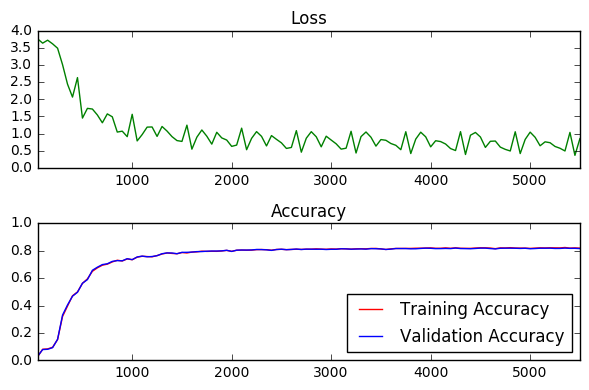

Time taken: 306.3164074420929


In [63]:
# Initialize variables
#init = tf.global_variables_initializer()
init = tf.initialize_all_variables()

batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

total_time = time.time()
# Launch graph
with tf.Session() as session:
    session.run(init)
    
    # Training cycle
    for epochs in range(training_epochs):
        start_time = time.time()
        avg_cost = 0.
        total_batch = int(len(train_features)/batch_size)
        
        for i in range(total_batch):
            idx_l = i*batch_size
            idx_h = idx_l + batch_size
            
            batch_x = train_features_f[idx_l:idx_h]
            batch_y = train_labels[idx_l:idx_h]
                        
            _,c = session.run([optimizer, cost], feed_dict = {network_input: batch_x, network_output: batch_y})
            
            # Compute average loss
            avg_cost += c / total_batch
            
       
        # Log every 50 batches
            if not i % 50:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict={network_input: train_features_f, network_output: train_labels})
                validation_accuracy = session.run(accuracy, feed_dict={network_input: valid_features_f, network_output: valid_labels})

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(50 + previous_batch)
                loss_batch.append(c)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)
                
        # Display logs per epoch step
        if epochs % display_step == 0:
            print("Epoch:", '%04d' % (epochs+1), "cost=", \
                "{:.9f}".format(avg_cost))
        end_time = time.time() - start_time
        print("Time after epoch: %s" %end_time)
        
        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict={network_input: valid_features_f, network_output: valid_labels})
        
    print("Optimization Finished!")
    
    test_accuracy = session.run(accuracy, feed_dict = 
                                            {network_input: X_test_gray_flat, network_output: y_test_oh})
    print("Training Accuracy:", training_accuracy)
    print("Validation Accuracy:", validation_accuracy)
    print("Test Accuracy:", test_accuracy)
    
    plot_loss_accuracy(batches, loss_batch, train_acc_batch, valid_acc_batch)
    
    final_time = time.time() - total_time
    print("Time taken: %s" %final_time)